# NOAA StormEvent data
## The historical cost of weather events: 1950 - 2018
### John Burt
#### April 2018

[To hide code cells, view this in nbviewer](https://nbviewer.jupyter.org/github/johnmburt/projects/tree/master/NOAA_weather_events/JMB_storm_data_cost_vf.ipynb) 


From Johnathan Mackrory, who prepared this dataset for Portland Data Science Group's 2018 data visualization meetup series:
>This looks at the StormEvent data. The data starts in 1950, and runs till today. As discussed on the webpage(https://www.ncdc.noaa.gov/stormevents/details.jsp), the amount of information tracked has changed over time. In the 50s only tornados were tracked, and was expanded to thunderstorms and hail in the 60s. The full panoply of events only started being collected in 1996. So around 20 years of "full" coverage. 

I wanted to create a simple bar chart showing the total cost of recorded weather events throughout the years in the dataset. It wasn't quite so simple as plotting summed costs though: I needed to adjust for inflation using CPI data.

#### Extra packages required:
- bokeh

#### The data:
- The data used in this figure runs about 232 MB. I've provided a [zipped version on my project github page](https://github.com/johnmburt/projects/tree/master/NOAA_weather_events/detail_trim1.zip). To use it, just unzip the data into the same folder as this notebook.


In [14]:
# javascript to hide / show notebook code
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [15]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import pickle

datafilename = 'detail_trim_most'

# first try to load the saved pickle file version, which is much quicker
try:
    with open(datafilename+'.pkl', 'rb') as handle:
        df = pickle.load(handle)

# if that fails, then load the csv version, fix it, and save it as pickle
except:
    # read the file
    df = pd.read_csv(datafilename+'.csv')

    # convert the various date and BEGIN time fields to a single date index
    datestr = df.YEAR.map(str) + ' ' + df.MONTH_NAME + ' ' + df.BEGIN_DAY.map(str) + ' ' + df.BEGIN_TIME.map(str).str.zfill(4)
    date = pd.to_datetime(datestr, format='%Y %B %d %H%M')
    df.insert(0, 'date', date)
    
    # pickle that sucker
    with open(datafilename+'.pkl', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
import seaborn as sns

# set some matplotlib params for all plots

# set all font sizes
matplotlib.rcParams.update({'font.size': 22})

# set all line widths
matplotlib.rcParams.update({'lines.linewidth': 3})

# set all symbol sizes
matplotlib.rcParams.update({'lines.markersize': 20})

matplotlib.rcParams.update({'axes.facecolor': 'white'})
matplotlib.rcParams.update({'axes.edgecolor': 'black'})

## graphing the cost of weather events.

Seaborn automatically makes a color gradient for bar charts. In most cases I'd avoid doing this, but here it looks nice.

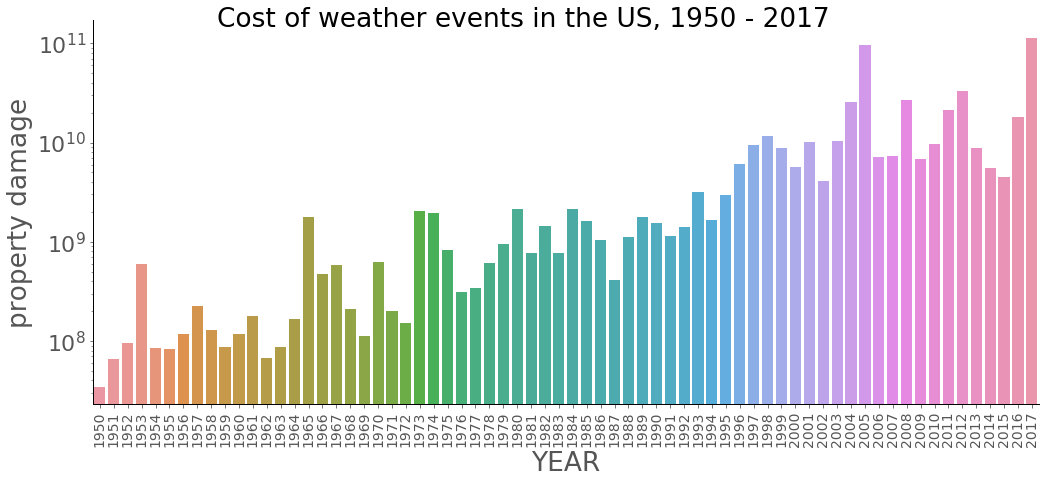

In [17]:
import seaborn as sns

# sum of costs for every year
dfyear = df.groupby(['YEAR'], as_index=False).sum()

plt.figure(figsize=(15, 7))
plt.suptitle("Cost of weather events in the US, 1950 - 2017")

ax=sns.barplot(x='YEAR',y='DAMAGE_PROPERTY', data=dfyear)
sns.despine()
plt.ylabel('property damage')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
plt.tight_layout()


## Need to adjust for inflation!!

The figure above shows a linear progression of weather cost, but this is at least partly due to inflation. Using CPI data, I corrected for inflation and replotted the figure.

Now, looking at an apples to apples comparison, it appears that weather damage costs increased slowly until about 1996, then increased. This seems like an interesting trend, but it probably actually reflects an increase in number of events recorded in the dataset in 1996. 

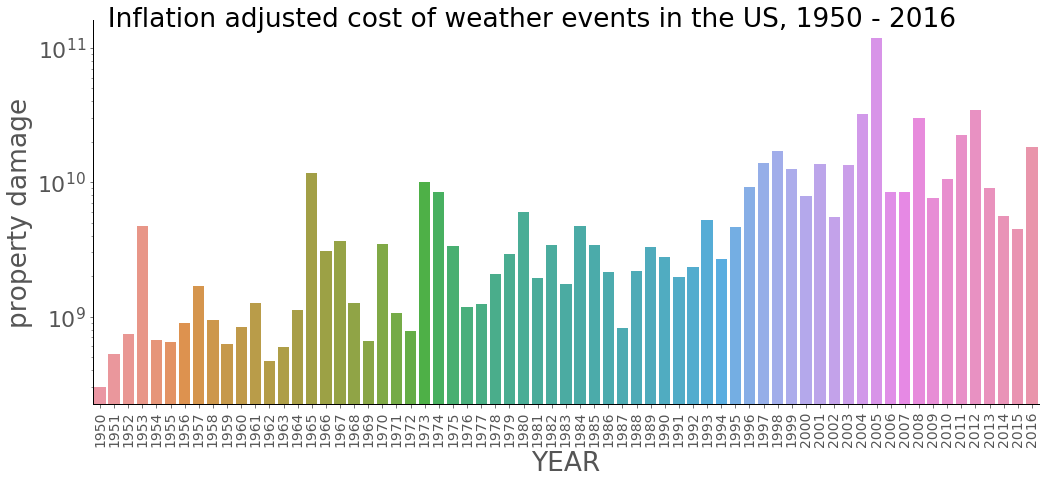

In [18]:
# load CPI data
indicator_file = "CPI_U_RS.csv"
indicator = pd.read_csv(indicator_file, index_col='year', encoding='utf-8')

# sum of costs for every year
dfyear = df.groupby(['YEAR'], as_index=False).sum()
dfyear = dfyear.drop(dfyear.index[-1])

# convert all cost values to 2018 inflation adjusted values
adjcost = []
CPI2016 = indicator.loc[2016]
for cost,year in zip(dfyear.DAMAGE_PROPERTY, dfyear.YEAR):
    costadj = (cost*CPI2016)/ indicator.loc[year]
    adjcost.append( costadj)
dfyear['damage_adjusted'] = adjcost               

# plot it
plt.figure(figsize=(15, 7))
plt.suptitle("  Inflation adjusted cost of weather events in the US, 1950 - 2016")

ax=sns.barplot(x='YEAR',y='damage_adjusted', data=dfyear)
sns.despine()
plt.ylabel('property damage')
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=14)
ax.set_yscale('log')
plt.tight_layout()
